In [1]:
import itertools
import os
import functools
import dataclasses
import packaging.version
import importlib
from typing import List, Sequence, Set, Iterator, Optional

import libmambapy
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import mamba_error_reporting as mer

pd.set_option("max_colwidth", None)
pd.set_option("display.max_columns", None)

%matplotlib inline

## Previous error message

In [2]:
# Reload all mer modules (for dev purposes)
for m in mer.__all__:
    importlib.reload(getattr(mer, m))
    
solver, pool = mer.problems.create_pubgrub_missing()

success = solver.solve()
if not success:
    print(mer.messaging.old_error_report(solver))

Mamba failed to solve. The reported errors are:
   Encountered problems while solving:
     - nothing provides libnothere >1.0 needed by dropdown-2.9.3
   


## Raw libsolv data

In [3]:
# Reload all mer modules (for dev purposes)
for m in mer.__all__:
    importlib.reload(getattr(mer, m))

pbs = mer.analysis.all_problems_structured_df(solver)
deps = mer.analysis.select_solvables_df(
    pool, pbs[~pbs.dependency.isnull()].dependency_id.drop_duplicates()
)
solvables = mer.analysis.id_to_pkg_info_df(pool,
    itertools.chain(
    pbs[pbs.source_is_pkg].source_id,
    pbs[pbs.target_is_pkg].target_id,
    deps.solvable_id
)).drop_duplicates().set_index('id').sort_index()

## Graph compression

==================================================== Original graph ====================================================


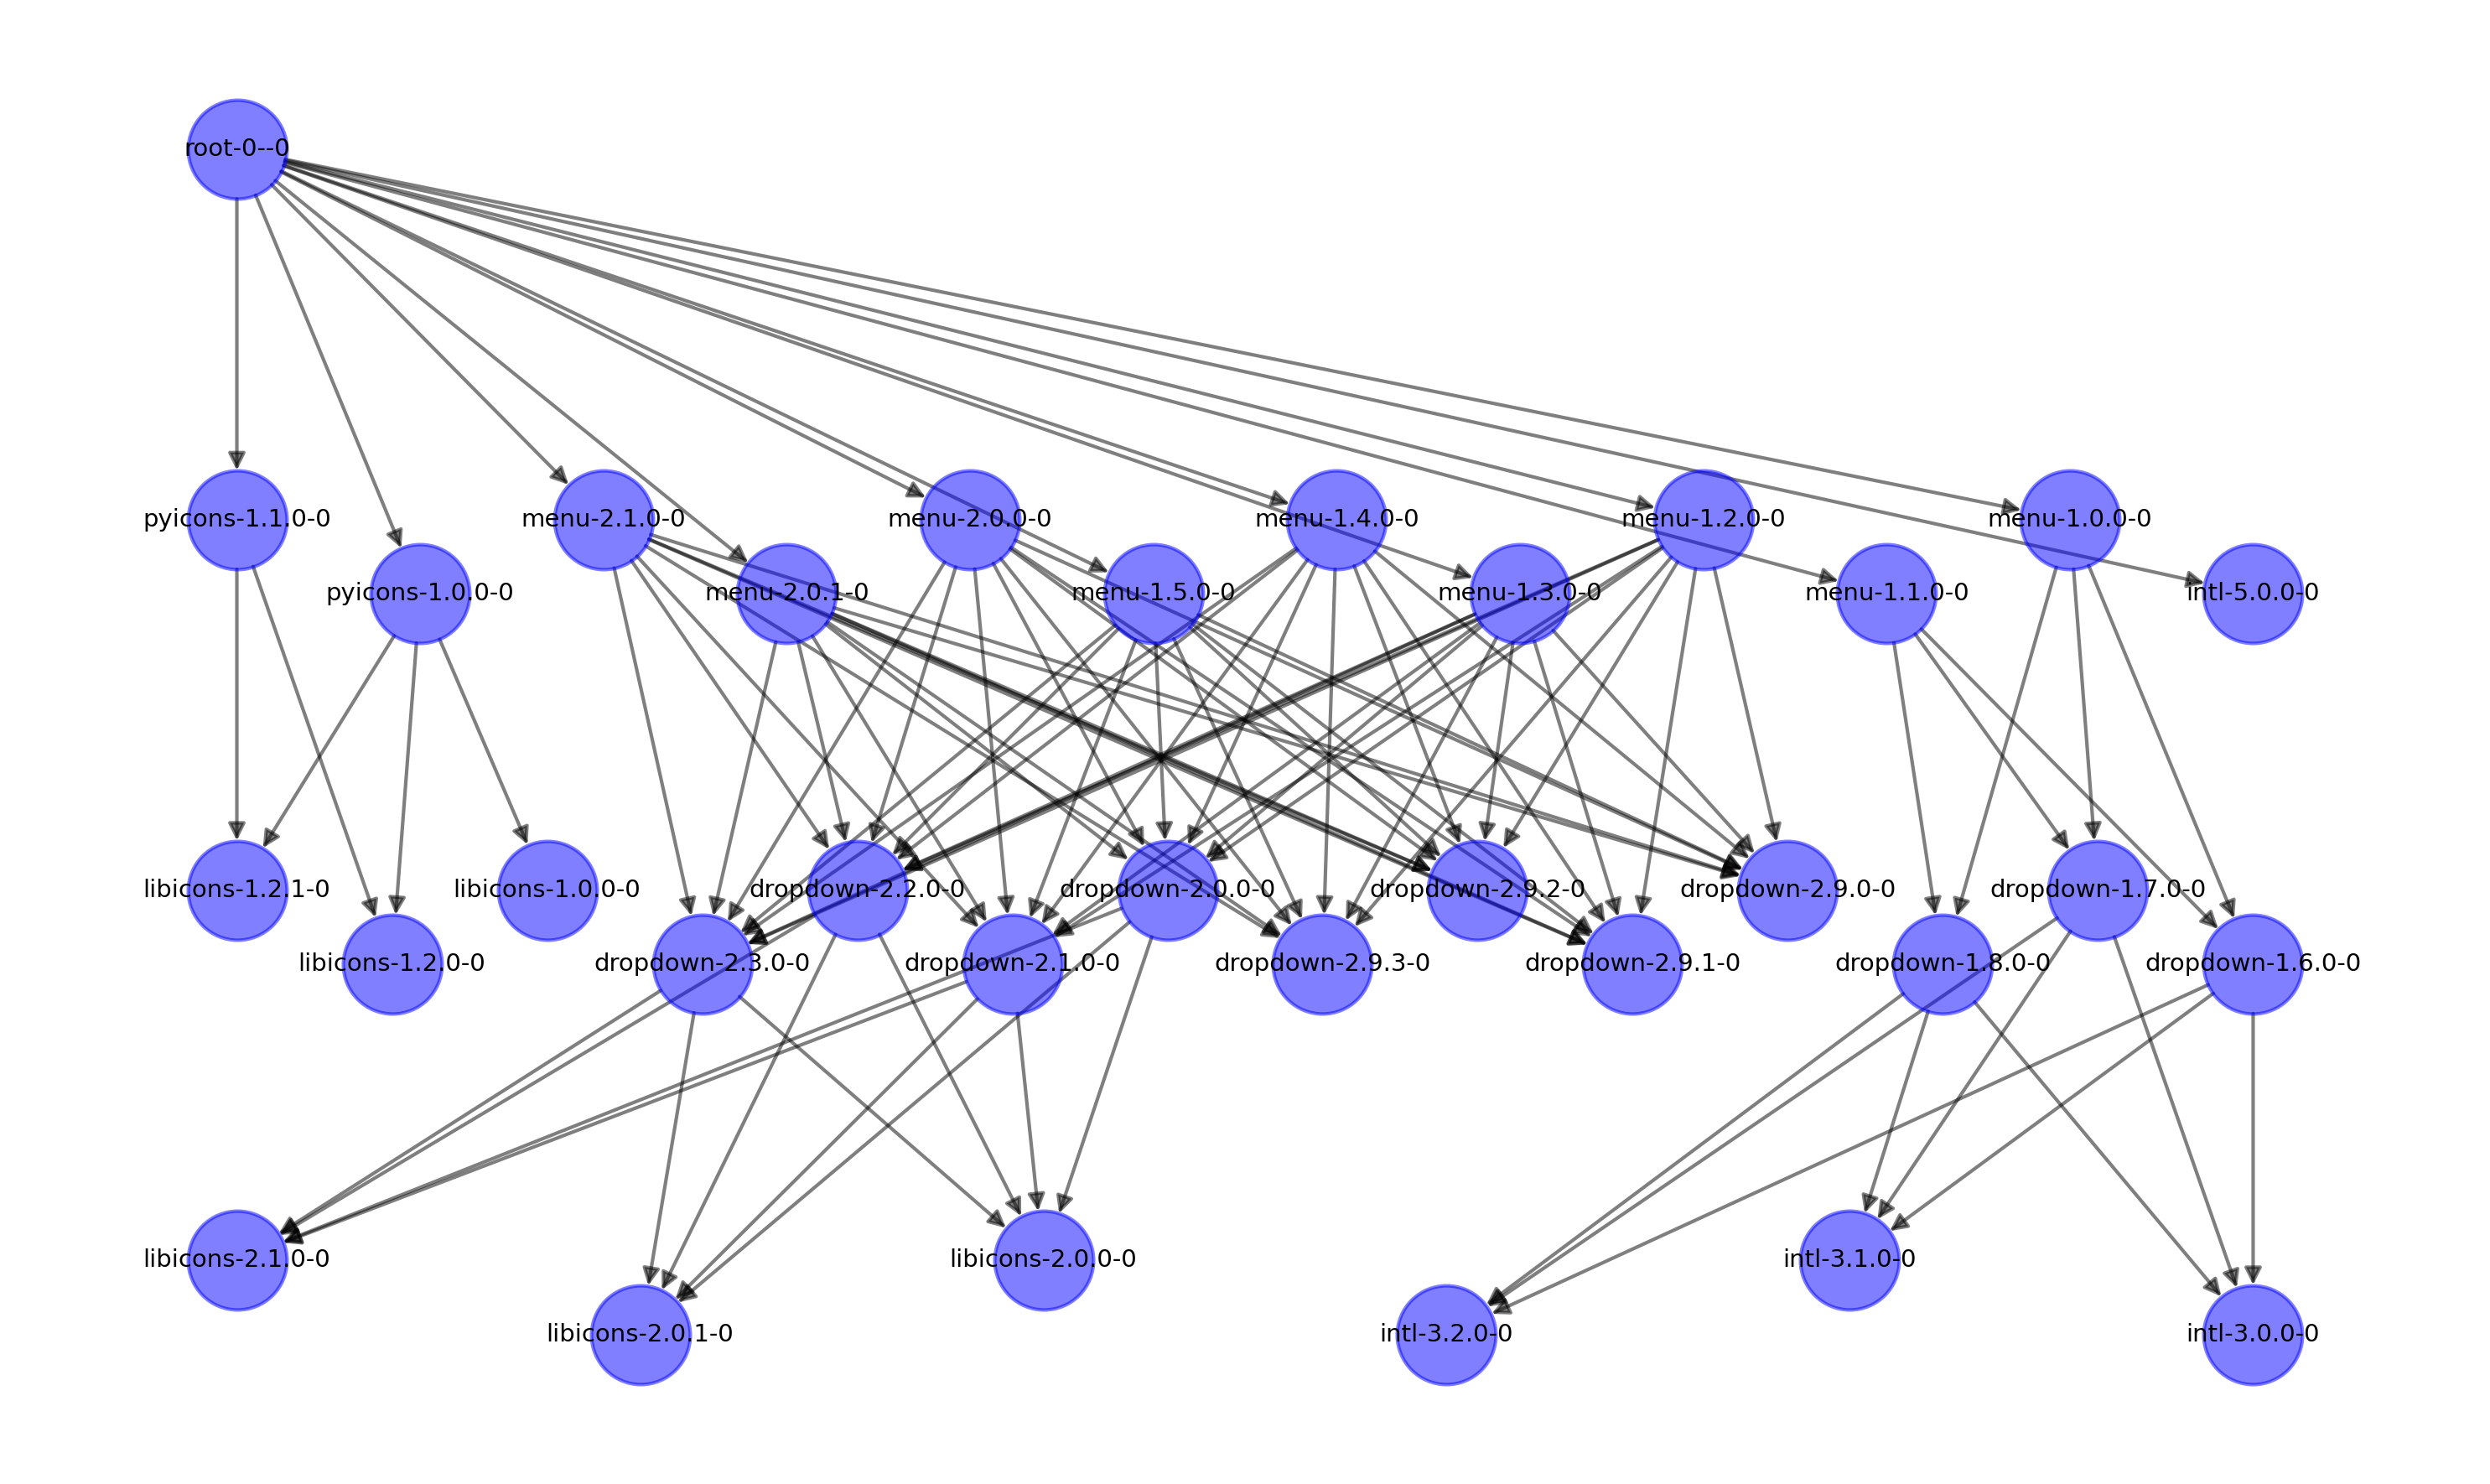

=================================================== Compressed graph ===================================================


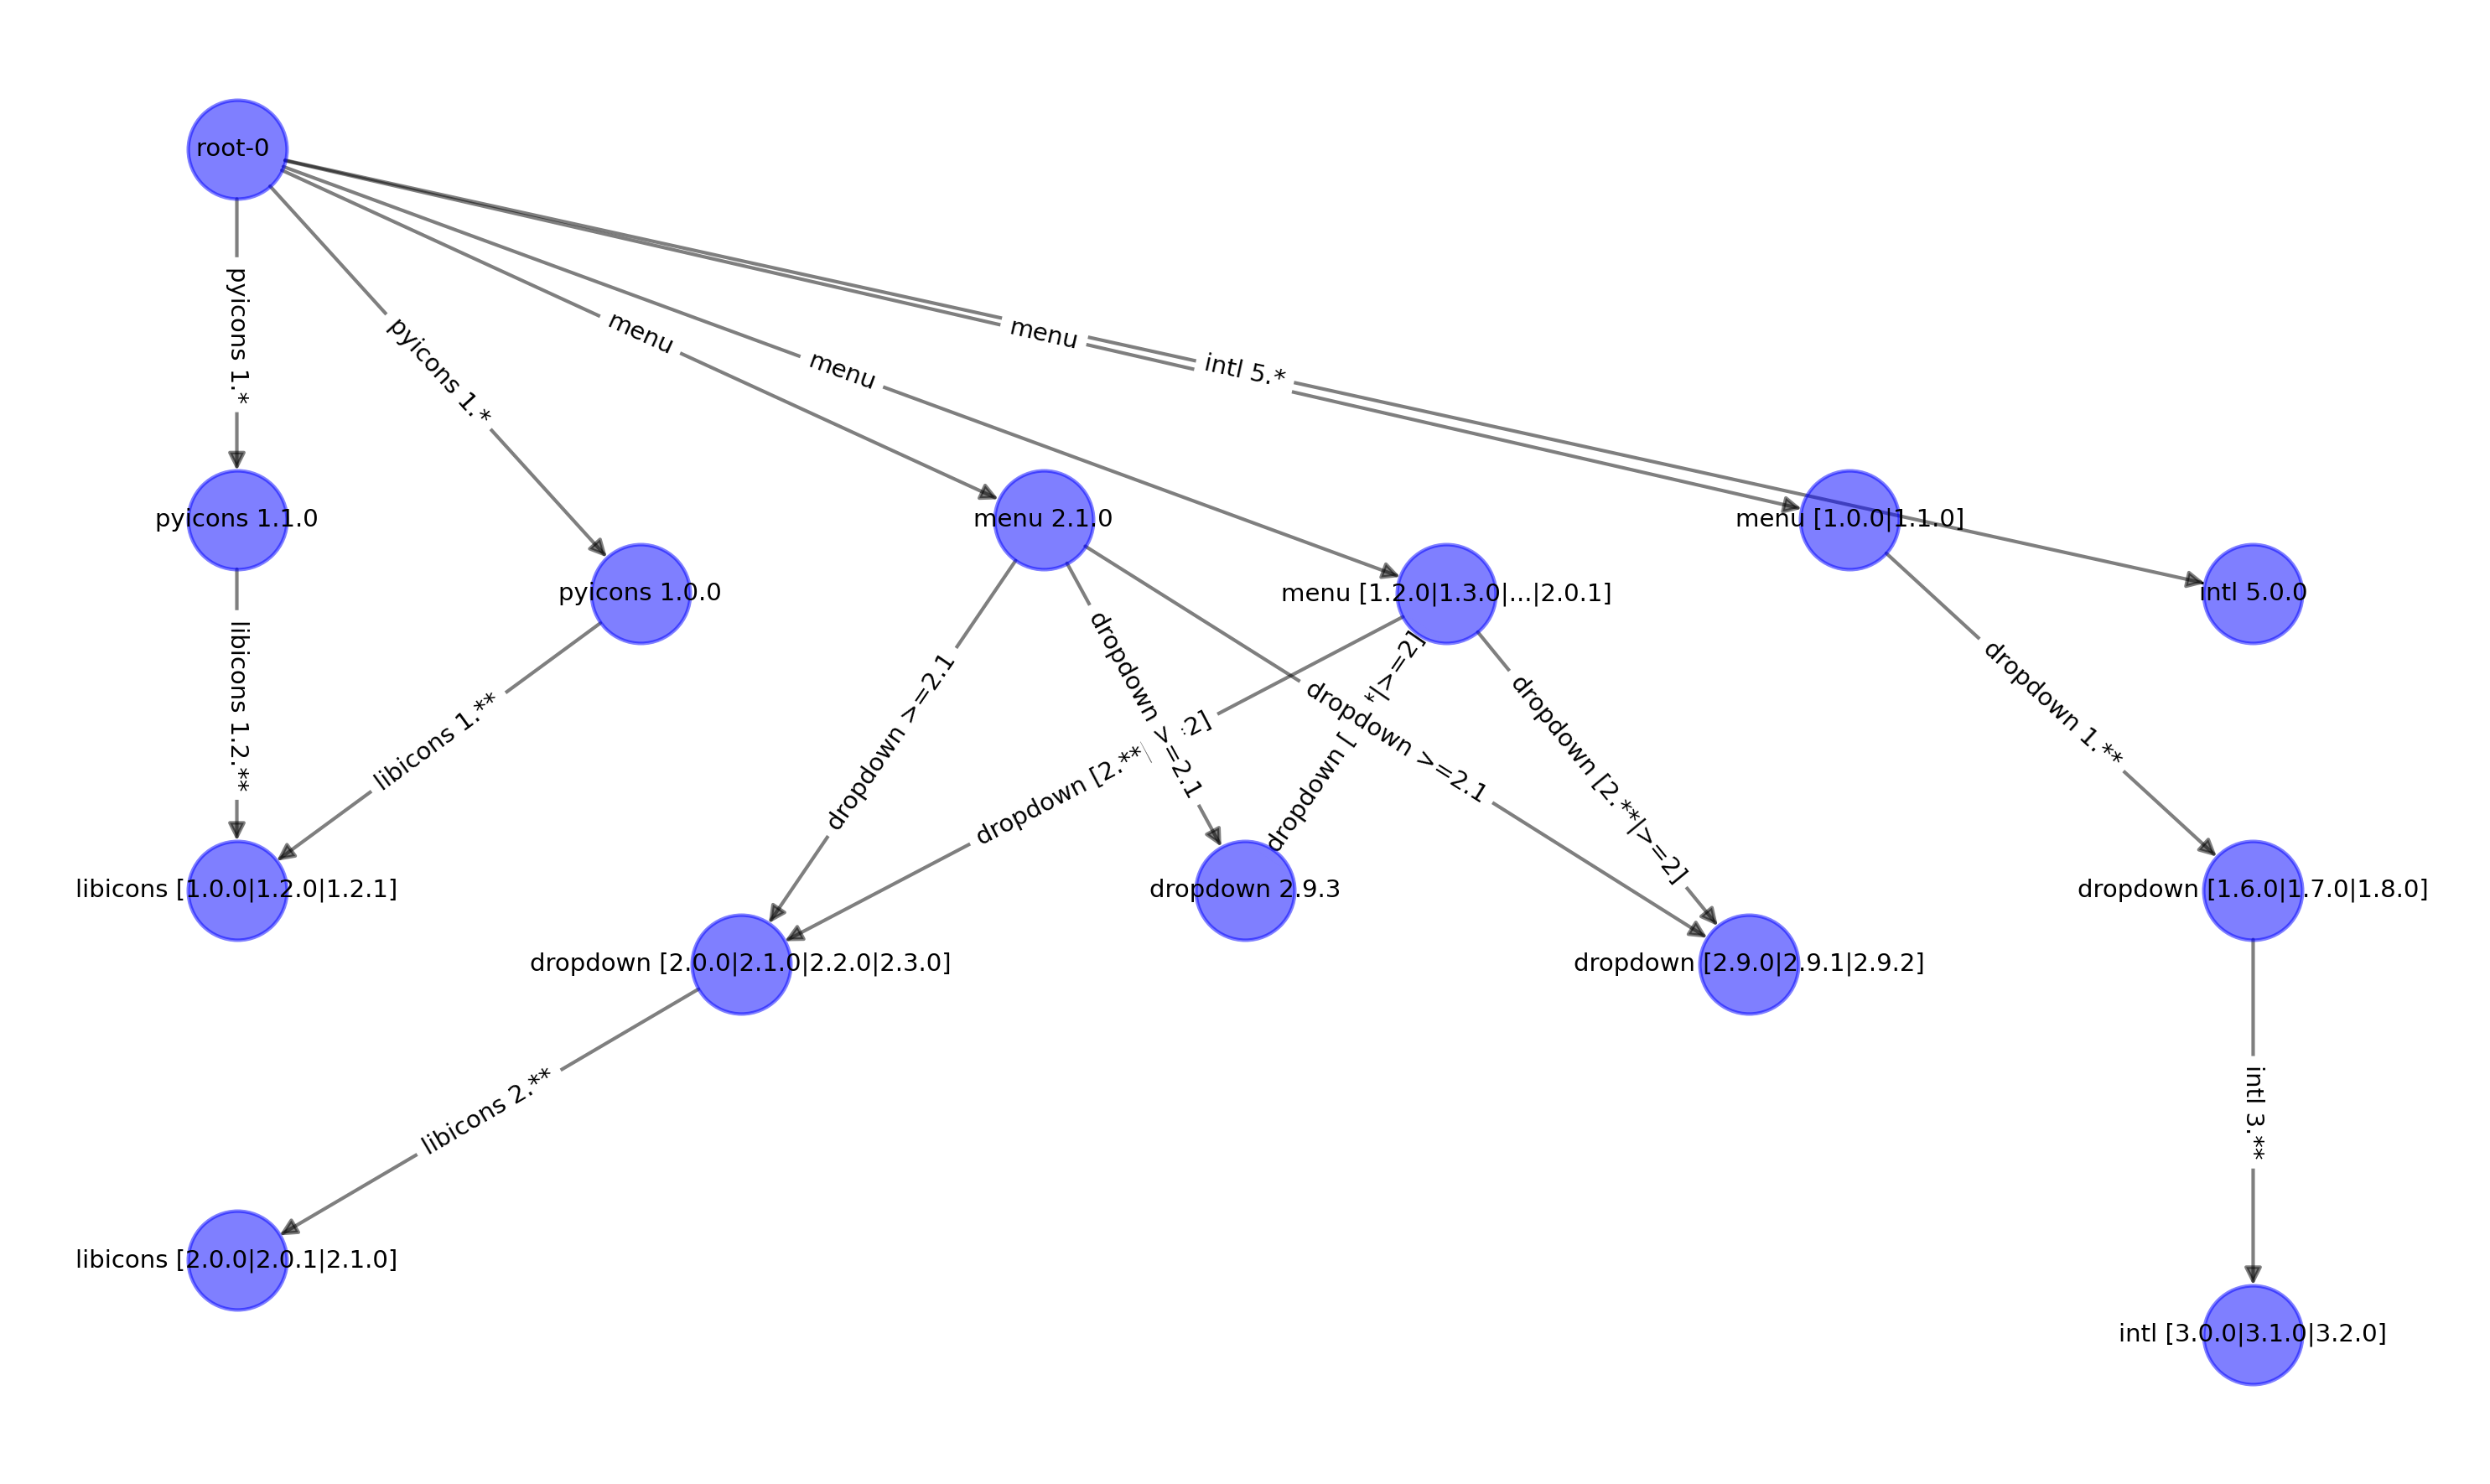

In [4]:
print("{:=^120}".format(" Original graph "))
pb_data = mer.algorithm.ProblemData.from_libsolv(solver, pool)
mer.plot.plot_solvable_dag(pb_data)
print("{:=^120}".format(" Compressed graph "))
cp_data = mer.algorithm.compress_graph(pb_data)
mer.plot.plot_group_dag(pb_data, cp_data)

## Error message

In [5]:
# Reload all mer modules (for dev purposes)
for m in mer.__all__:
    importlib.reload(getattr(mer, m))

print(mer.algorithm.explain_graph(pb_data, cp_data))

Error: Could not find any compatible versions for requested packages menu, intl 5.*, pyicons 1.*.

The following packages conflict with one another
├─ pyicons 1.* is installable with the potential options
│  ├─ pyicons 1.0.0, which requires
│  │  └─ libicons 1.**, which can be installed;
│  └─ pyicons 1.1.0, which requires
│     └─ libicons 1.2.**, which can be installed;
├─ menu is installable with the potential options
│  ├─ menu [1.0.0|1.1.0], which requires
│  │  └─ dropdown 1.**, which requires
│  │     └─ intl 3.**, which can be installed;
│  ├─ menu [1.2.0|1.3.0|...|2.0.1], which requires
│  │  └─ dropdown [2.**|>=2] with no viable options
│  │     ├─ dropdown [2.0.0|2.1.0|2.2.0|2.3.0], which cannot be installed (as previously explained);
│  │     ├─ dropdown [2.9.0|2.9.1|2.9.2], which requires the missing package libicons >10.0;
│  │     └─ dropdown 2.9.3, which requires the missing package libnothere >1.0;
│  └─ menu 2.1.0, which requires
│     └─ dropdown >=2.1 with no viable